In [2]:
# Imports
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np

In [3]:
# Read md data
df = pd.read_csv("../Accident_Data_Preprocessing/Data_Raw/full_data/mdtraffic.csv")


In [3]:
# View data, remove duplicate rows
df.head()
df = df.drop_duplicates()

In [4]:
# Check all unique values for all columns
for col in df.columns:
    print(df[col].value_counts(sort=True))

ID
A-7777383    1
A-7774726    1
A-7774727    1
A-7774733    1
A-7774736    1
            ..
A-228580     1
A-228630     1
A-228632     1
A-228641     1
A-228649     1
Name: count, Length: 140417, dtype: int64
Source
Source1    98441
Source2    41321
Source3      655
Name: count, dtype: int64
Severity
2    103558
3     25450
4     10892
1       517
Name: count, dtype: int64
Start_Time
2021-05-28 07:31:48    30
2022-05-18 07:05:30    22
2021-11-06 16:59:00    19
2022-04-23 18:32:30    17
2020-06-26 18:14:49    17
                       ..
2019-08-15 16:21:25     1
2019-08-15 18:25:50     1
2019-08-16 19:57:05     1
2019-08-16 19:59:23     1
2016-12-01 06:35:00     1
Name: count, Length: 117296, dtype: int64
End_Time
2022-07-15 15:23:55    10
2020-12-19 00:51:28    10
2021-02-22 12:48:14    10
2020-04-30 16:37:30     9
2021-05-28 09:11:52     9
                       ..
2019-08-15 16:50:26     1
2019-08-15 18:53:25     1
2019-08-16 20:26:17     1
2019-08-16 20:28:09     1
2016-11-30 17:0

In [5]:
# Worth keeping weather time stamp? Examine value types
print(df["Weather_Timestamp"].value_counts(sort=True))

Weather_Timestamp
2022-03-13 01:55:00    64
2021-05-28 07:58:00    34
2022-05-18 06:52:00    29
2021-02-04 14:56:00    26
2021-11-06 16:55:00    25
                       ..
2019-08-14 15:08:00     1
2019-08-14 15:23:00     1
2019-08-14 16:43:00     1
2019-08-10 09:54:00     1
2019-08-10 18:56:00     1
Name: count, Length: 70648, dtype: int64


In [6]:
# Check all values of all remaining cols
for col in df.columns:
    print(df[col].value_counts(sort=True))

ID
A-7777383    1
A-7774726    1
A-7774727    1
A-7774733    1
A-7774736    1
            ..
A-228580     1
A-228630     1
A-228632     1
A-228641     1
A-228649     1
Name: count, Length: 140417, dtype: int64
Source
Source1    98441
Source2    41321
Source3      655
Name: count, dtype: int64
Severity
2    103558
3     25450
4     10892
1       517
Name: count, dtype: int64
Start_Time
2021-05-28 07:31:48    30
2022-05-18 07:05:30    22
2021-11-06 16:59:00    19
2022-04-23 18:32:30    17
2020-06-26 18:14:49    17
                       ..
2019-08-15 16:21:25     1
2019-08-15 18:25:50     1
2019-08-16 19:57:05     1
2019-08-16 19:59:23     1
2016-12-01 06:35:00     1
Name: count, Length: 117296, dtype: int64
End_Time
2022-07-15 15:23:55    10
2020-12-19 00:51:28    10
2021-02-22 12:48:14    10
2020-04-30 16:37:30     9
2021-05-28 09:11:52     9
                       ..
2019-08-15 16:50:26     1
2019-08-15 18:53:25     1
2019-08-16 20:26:17     1
2019-08-16 20:28:09     1
2016-11-30 17:0

In [7]:
# Date/time conversion, calculate length of traffic holdup in hours/fractions of an hour
df['Start_Time'] = pd.to_datetime(df['Start_Time'],format='mixed')
df['End_Time'] = pd.to_datetime(df['End_Time'], format = 'mixed')
df

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-228553,Source2,2,2016-11-30 11:58:01,2016-11-30 16:57:20,39.152046,-76.645584,NaN,NaN,0.010,...,False,False,False,False,False,False,Day,Day,Day,Day
1,A-228554,Source2,3,2016-11-30 12:04:03,2016-11-30 17:02:36,39.152046,-76.645584,NaN,NaN,0.010,...,False,False,False,False,False,False,Day,Day,Day,Day
2,A-228567,Source2,2,2016-11-30 16:54:53,2016-11-30 17:24:12,39.481083,-76.249626,NaN,NaN,0.010,...,False,False,False,False,True,False,Night,Day,Day,Day
3,A-228574,Source2,2,2016-11-30 17:33:47,2016-11-30 18:01:49,39.158756,-76.718475,NaN,NaN,0.010,...,False,False,False,False,False,False,Night,Night,Day,Day
4,A-228580,Source2,2,2016-11-30 17:35:33,2016-11-30 18:05:10,39.636391,-77.710457,NaN,NaN,0.010,...,False,False,False,False,True,False,Night,Night,Day,Day
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140412,A-7776879,Source1,2,2019-08-22 19:48:26,2019-08-22 20:17:11,39.494560,-76.892370,39.49561,-76.89158,0.084,...,False,False,False,False,False,False,Day,Day,Day,Day
140413,A-7776880,Source1,2,2019-08-22 19:48:26,2019-08-22 20:17:11,39.495610,-76.891580,39.49456,-76.89237,0.084,...,False,False,False,False,True,False,Day,Day,Day,Day
140414,A-7776881,Source1,4,2019-08-22 19:57:25,2019-08-23 00:56:06,39.600500,-77.677230,39.60544,-77.73422,3.053,...,False,False,False,False,False,False,Night,Day,Day,Day
140415,A-7777364,Source1,2,2019-08-23 08:03:29,2019-08-23 08:32:31,39.336120,-76.491730,39.33962,-76.49409,0.273,...,False,False,False,False,False,False,Day,Day,Day,Day


In [8]:
# Check unique values for all cols again
for col in df.columns:
    print(df[col].value_counts(sort=True))

ID
A-7777383    1
A-7774726    1
A-7774727    1
A-7774733    1
A-7774736    1
            ..
A-228580     1
A-228630     1
A-228632     1
A-228641     1
A-228649     1
Name: count, Length: 140417, dtype: int64
Source
Source1    98441
Source2    41321
Source3      655
Name: count, dtype: int64
Severity
2    103558
3     25450
4     10892
1       517
Name: count, dtype: int64
Start_Time
2021-05-28 07:31:48    34
2022-05-18 07:05:30    29
2022-04-23 18:32:30    24
2021-11-06 16:59:00    24
2022-07-15 14:05:49    22
                       ..
2019-08-15 16:21:25     1
2019-08-15 18:25:50     1
2019-08-16 19:57:05     1
2019-08-16 19:59:23     1
2016-12-01 17:58:44     1
Name: count, Length: 111577, dtype: int64
End_Time
2022-07-15 15:23:55    14
2020-12-19 00:51:28    10
2021-02-22 12:48:14    10
2021-05-28 09:11:52    10
2022-03-12 16:54:44    10
                       ..
2019-08-15 16:50:26     1
2019-08-15 18:53:25     1
2019-08-16 20:26:17     1
2019-08-16 20:28:09     1
2016-11-30 18:0

In [9]:
# Error checking of date time error I was getting over and over (One row had date and time recorded with higher
# granularity)
df.iloc[46456, :]

ID                                                               A-3710810
Source                                                             Source1
Severity                                                                 2
Start_Time                                             2022-05-12 23:39:31
End_Time                                               2022-05-13 00:54:33
Start_Lat                                                        38.804332
Start_Lng                                                       -76.906416
End_Lat                                                          38.804518
End_Lng                                                         -76.906239
Distance(mi)                                                         0.016
Description              Incident on ALLENTOWN RD near ALLENTOWN RD Dri...
Street                                                                 NaN
City                                                          Temple Hills
County                   

In [10]:
# Create year, month, and day columns out of date time
df['Year'], df['Month'], df['Day'] = df['Start_Time'].dt.year, df['Start_Time'].dt.month, df['Start_Time'].dt.day
df

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Year,Month,Day
0,A-228553,Source2,2,2016-11-30 11:58:01,2016-11-30 16:57:20,39.152046,-76.645584,NaN,NaN,0.010,...,False,False,False,Day,Day,Day,Day,2016,11,30
1,A-228554,Source2,3,2016-11-30 12:04:03,2016-11-30 17:02:36,39.152046,-76.645584,NaN,NaN,0.010,...,False,False,False,Day,Day,Day,Day,2016,11,30
2,A-228567,Source2,2,2016-11-30 16:54:53,2016-11-30 17:24:12,39.481083,-76.249626,NaN,NaN,0.010,...,False,True,False,Night,Day,Day,Day,2016,11,30
3,A-228574,Source2,2,2016-11-30 17:33:47,2016-11-30 18:01:49,39.158756,-76.718475,NaN,NaN,0.010,...,False,False,False,Night,Night,Day,Day,2016,11,30
4,A-228580,Source2,2,2016-11-30 17:35:33,2016-11-30 18:05:10,39.636391,-77.710457,NaN,NaN,0.010,...,False,True,False,Night,Night,Day,Day,2016,11,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140412,A-7776879,Source1,2,2019-08-22 19:48:26,2019-08-22 20:17:11,39.494560,-76.892370,39.49561,-76.89158,0.084,...,False,False,False,Day,Day,Day,Day,2019,8,22
140413,A-7776880,Source1,2,2019-08-22 19:48:26,2019-08-22 20:17:11,39.495610,-76.891580,39.49456,-76.89237,0.084,...,False,True,False,Day,Day,Day,Day,2019,8,22
140414,A-7776881,Source1,4,2019-08-22 19:57:25,2019-08-23 00:56:06,39.600500,-77.677230,39.60544,-77.73422,3.053,...,False,False,False,Night,Day,Day,Day,2019,8,22
140415,A-7777364,Source1,2,2019-08-23 08:03:29,2019-08-23 08:32:31,39.336120,-76.491730,39.33962,-76.49409,0.273,...,False,False,False,Day,Day,Day,Day,2019,8,23


In [11]:
def season(x):
    tomap = {1:"Winter",2:"Winter",3:"Spring",4:"Spring",5:"Spring",6:"Summer",7:"Summer",8:"Summer",9:"Fall",10:"Fall",11:"Fall",12:"Winter"}
    if x in tomap:
        return tomap[x]
    return x

In [12]:
df['Start_Time'] = pd.to_datetime(df['Start_Time'],format='mixed')
df['Month'] = df['Start_Time'].dt.month
df["Season"] = df.Month.apply(season)
df['Season'].value_counts()

Season
Winter    40320
Fall      38097
Spring    31212
Summer    30788
Name: count, dtype: int64

In [13]:
# Convert street names to strings
df['Street']=df['Street'].astype(str)

In [14]:
def street_type(x):
    if "Tunl" in x or "Tunnel" in x:
        return "Tunnel"#nsew(x,"Tunnel")
    if "I-" in x:
        return "Interstate"
    if " Dr " in x or " Ave " in x or " Rd " in x or " Xing" in x or " Way " in x:
        return "local"
    if "Beltway" in x:
        return "Beltway"
    if "US-" in x[:4] or "MD-" in x[:4] or "Expy" in x:
        return "Highway"
    if "Hwy" in x or "Fwy" in x or "Highway" in x or "Route" in x or "Connector" in x or "Byp" in x or "Bypass" in x or "Gtwy" in x or "Brg" in x or "Trwy" in x:
        return "Highway"
    if x[-2:] in ["St","Pl","Dr","Sq"]:
        return "local"
    if "Ln" in x or "Rd" in x or "Ct" in x:
        return "local"
    if x[-3:] in ["Way","Cir","Ter","Trl","Plz","Aly","Grn","way","Ext"]:
        return "local"
    if "Ave" in x[-5:] or " Blvd" in x or " Pike" in x or "Pkwy" in x or "Crse" in x or "Alameda" in x:
        return "large_local"
    if "Garth" in x or "Spell" in x or "Psge" in x or "Chase" in x or "Cutoff" in x or "Spire" in x:
        return "local"
    if "Overlook" in x or "Battlefield" in x or "Cemetery" in x or "Park" in x or "Base" in x or "Concourse" in x or "Memorial" in x:
        return "special"
    if "Loop" in x or "Greenway" in x or "West" in x or "ville" in x or "wood" in x:
        return "local"
    
    return x

In [15]:
df["Street"] = df.Street.apply(street_type)

In [16]:
#df=df.loc[~df.Street.str.contains("special")]
df

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Year,Month,Day,Season
0,A-228553,Source2,2,2016-11-30 11:58:01,2016-11-30 16:57:20,39.152046,-76.645584,NaN,NaN,0.010,...,False,False,Day,Day,Day,Day,2016,11,30,Fall
1,A-228554,Source2,3,2016-11-30 12:04:03,2016-11-30 17:02:36,39.152046,-76.645584,NaN,NaN,0.010,...,False,False,Day,Day,Day,Day,2016,11,30,Fall
2,A-228567,Source2,2,2016-11-30 16:54:53,2016-11-30 17:24:12,39.481083,-76.249626,NaN,NaN,0.010,...,True,False,Night,Day,Day,Day,2016,11,30,Fall
3,A-228574,Source2,2,2016-11-30 17:33:47,2016-11-30 18:01:49,39.158756,-76.718475,NaN,NaN,0.010,...,False,False,Night,Night,Day,Day,2016,11,30,Fall
4,A-228580,Source2,2,2016-11-30 17:35:33,2016-11-30 18:05:10,39.636391,-77.710457,NaN,NaN,0.010,...,True,False,Night,Night,Day,Day,2016,11,30,Fall
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140412,A-7776879,Source1,2,2019-08-22 19:48:26,2019-08-22 20:17:11,39.494560,-76.892370,39.49561,-76.89158,0.084,...,False,False,Day,Day,Day,Day,2019,8,22,Summer
140413,A-7776880,Source1,2,2019-08-22 19:48:26,2019-08-22 20:17:11,39.495610,-76.891580,39.49456,-76.89237,0.084,...,True,False,Day,Day,Day,Day,2019,8,22,Summer
140414,A-7776881,Source1,4,2019-08-22 19:57:25,2019-08-23 00:56:06,39.600500,-77.677230,39.60544,-77.73422,3.053,...,False,False,Night,Day,Day,Day,2019,8,22,Summer
140415,A-7777364,Source1,2,2019-08-23 08:03:29,2019-08-23 08:32:31,39.336120,-76.491730,39.33962,-76.49409,0.273,...,False,False,Day,Day,Day,Day,2019,8,23,Summer


In [17]:
df.Street.value_counts()

Street
Interstate                            38841
local                                 34389
large_local                           24719
Highway                               24649
Beltway                               14316
                                      ...  
Harriet Tubman Underground RR Bywy        1
4B                                        1
13C                                       1
 Fraternity Row                           1
US 50                                     1
Name: count, Length: 128, dtype: int64

In [18]:
# Proper formatting of county names (I took an educated guess that \"Baltimore\" referred to Balt. County and not City, this
# may not be correct)

def replace_misspelled(text):
    corrections = {"St Mary's": "St. Marys", "Prince George's": "Prince Georges", "Queen Anne's": "Queen Annes",
                   "Baltimore (City)":"Baltimore City","Saint Mary's":"St Marys", "Baltimore County":"Baltimore",
                   "St. Mary's":"St Marys", "Saint Marys":"St Marys"}
    for word, correction in corrections.items():
        text = text.replace(word, correction)
    return text

df['County'] = df['County'].apply(replace_misspelled)
df["County"].value_counts(sort=True)

County
Prince Georges          27143
Montgomery              22565
Baltimore               22374
Frederick               13056
Anne Arundel            11950
Baltimore City          10216
Harford                  6802
Howard                   6134
Washington               4848
Cecil                    2482
Queen Annes              2436
Charles                  2037
Carroll                  1360
Talbot                   1179
Worcester                1154
Caroline                  908
Allegany                  770
St Marys                  658
Wicomico                  621
Dorchester                593
Garrett                   360
Kent                      328
Calvert                   223
Somerset                  216
District Of Columbia        4
Name: count, dtype: int64

In [19]:
# One hot function (Could not find the one line function Dr. Olsen referred to)
def onehotinator(df, string):
    one_hot = pd.get_dummies(df[string], prefix=string)
    one_hot = one_hot.astype(int)
    df = df.join(one_hot)
    df = df.drop(columns=string)
    return df

In [20]:
# Boolean column feature for if snowy OR icy conditions were present
lst = ['Snow', 'Freezing', 'Ice', 'Wintry', 'Hail', 'Sleet']
df['Snow_Ice']=np.where(df['Weather_Condition'].str.contains('|'.join(lst), na=False), True, False)

In [21]:
# Boolean column feature for if mist OR fog OR haze was present, OR if visibility in miles was less than 0.001 mi
lst = ['Fog', 'Mist', 'Haze', 'Heavy']
df['Low_Vis_Weather']=np.where((df['Weather_Condition'].str.contains('|'.join(lst), na=False) | df["Visibility(mi)"] < 0.001), True, False)

In [22]:
# Boolean column feature for if road conditions were wet (weather was rain/storm related, OR there was more than 0 inches
# of precipitation at time of crash)
lst = ['Rain', 'Drizzle', 'Thunderstorm', 'T-Storm', 'Precipitation']
df['Rainy']=np.where((df['Weather_Condition'].str.contains('|'.join(lst), na=False) | df['Precipitation(in)'] >= 0.01), True, False)

In [23]:
# Check which columns to delete
df


,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Year,Month,Day,Season,Snow_Ice,Low_Vis_Weather,Rainy
0,A-228553,Source2,2,2016-11-30 11:58:01,2016-11-30 16:57:20,39.152046,-76.645584,NaN,NaN,0.010,...,Day,Day,Day,2016,11,30,Fall,False,False,False
1,A-228554,Source2,3,2016-11-30 12:04:03,2016-11-30 17:02:36,39.152046,-76.645584,NaN,NaN,0.010,...,Day,Day,Day,2016,11,30,Fall,False,False,False
2,A-228567,Source2,2,2016-11-30 16:54:53,2016-11-30 17:24:12,39.481083,-76.249626,NaN,NaN,0.010,...,Day,Day,Day,2016,11,30,Fall,False,False,True
3,A-228574,Source2,2,2016-11-30 17:33:47,2016-11-30 18:01:49,39.158756,-76.718475,NaN,NaN,0.010,...,Night,Day,Day,2016,11,30,Fall,False,False,False
4,A-228580,Source2,2,2016-11-30 17:35:33,2016-11-30 18:05:10,39.636391,-77.710457,NaN,NaN,0.010,...,Night,Day,Day,2016,11,30,Fall,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140412,A-7776879,Source1,2,2019-08-22 19:48:26,2019-08-22 20:17:11,39.494560,-76.892370,39.49561,-76.89158,0.084,...,Day,Day,Day,2019,8,22,Summer,False,False,True
140413,A-7776880,Source1,2,2019-08-22 19:48:26,2019-08-22 20:17:11,39.495610,-76.891580,39.49456,-76.89237,0.084,...,Day,Day,Day,2019,8,22,Summer,False,False,True
140414,A-7776881,Source1,4,2019-08-22 19:57:25,2019-08-23 00:56:06,39.600500,-77.677230,39.60544,-77.73422,3.053,...,Day,Day,Day,2019,8,22,Summer,False,False,False
140415,A-7777364,Source1,2,2019-08-23 08:03:29,2019-08-23 08:32:31,39.336120,-76.491730,39.33962,-76.49409,0.273,...,Day,Day,Day,2019,8,23,Summer,False,False,False


In [24]:
# Remove all but one day/night column

df = df.drop(columns=['Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight', 'Weather_Condition'])
df['Sunrise_Sunset'] = df['Sunrise_Sunset'].astype("string")

#df = df.dropna(subset = ['Sunrise_Sunset'], axis = 0)
df['Sunrise_Sunset'].value_counts()

Sunrise_Sunset
Day      93834
Night    46297
Name: count, dtype: Int64

In [25]:
# Reference for data conversion
df.dtypes

ID                           object
Source                       object
Severity                      int64
Start_Time           datetime64[ns]
End_Time             datetime64[ns]
Start_Lat                   float64
Start_Lng                   float64
End_Lat                     float64
End_Lng                     float64
Distance(mi)                float64
Description                  object
Street                       object
City                         object
County                       object
State                        object
Zipcode                      object
Country                      object
Timezone                     object
Airport_Code                 object
Weather_Timestamp            object
Temperature(F)              float64
Wind_Chill(F)               float64
Humidity(%)                 float64
Pressure(in)                float64
Visibility(mi)              float64
Wind_Direction               object
Wind_Speed(mph)             float64
Precipitation(in)           

In [26]:
# Convert all boolean columns to 1/0 integer columns and only day/night column to 1/0

bools = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 
         'Traffic_Signal', 'Turning_Loop', 'Low_Vis_Weather', 'Snow_Ice', 'Rainy']

for i in bools:
    df = df.astype({i:int})
df['Sunrise_Sunset'] = df["Sunrise_Sunset"].map({'Day':1,'Night':0})
df.dtypes

ID                           object
Source                       object
Severity                      int64
Start_Time           datetime64[ns]
End_Time             datetime64[ns]
Start_Lat                   float64
Start_Lng                   float64
End_Lat                     float64
End_Lng                     float64
Distance(mi)                float64
Description                  object
Street                       object
City                         object
County                       object
State                        object
Zipcode                      object
Country                      object
Timezone                     object
Airport_Code                 object
Weather_Timestamp            object
Temperature(F)              float64
Wind_Chill(F)               float64
Humidity(%)                 float64
Pressure(in)                float64
Visibility(mi)              float64
Wind_Direction               object
Wind_Speed(mph)             float64
Precipitation(in)           

In [27]:
def slowdown_level(row):
    return sum([row['Bump'],row["Crossing"], \
    row["Give_Way"], row["Junction"], row["Railway"],  \
    row['Roundabout'], row["Stop"], row["Traffic_Calming"], \
    row["Traffic_Signal"], row["Turning_Loop"]])
df['Qty_Slowing_Elements'] = df.apply(slowdown_level, axis=1)
df['Qty_Slowing_Elements'].value_counts()

Qty_Slowing_Elements
0    102613
1     31069
2      6273
3       455
4         7
Name: count, dtype: int64

In [28]:
df.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Turning_Loop,Sunrise_Sunset,Year,Month,Day,Season,Snow_Ice,Low_Vis_Weather,Rainy,Qty_Slowing_Elements
0,A-228553,Source2,2,2016-11-30 11:58:01,2016-11-30 16:57:20,39.152046,-76.645584,NaN,NaN,0.01,...,0,1.0,2016,11,30,Fall,0,0,0,0
1,A-228554,Source2,3,2016-11-30 12:04:03,2016-11-30 17:02:36,39.152046,-76.645584,NaN,NaN,0.01,...,0,1.0,2016,11,30,Fall,0,0,0,0
2,A-228567,Source2,2,2016-11-30 16:54:53,2016-11-30 17:24:12,39.481083,-76.249626,NaN,NaN,0.01,...,0,0.0,2016,11,30,Fall,0,0,1,1
3,A-228574,Source2,2,2016-11-30 17:33:47,2016-11-30 18:01:49,39.158756,-76.718475,NaN,NaN,0.01,...,0,0.0,2016,11,30,Fall,0,0,0,1
4,A-228580,Source2,2,2016-11-30 17:35:33,2016-11-30 18:05:10,39.636391,-77.710457,NaN,NaN,0.01,...,0,0.0,2016,11,30,Fall,0,0,1,1


In [29]:
# Reference for what to do next
df.isnull().sum()

ID                          0
Source                      0
Severity                    0
Start_Time                  0
End_Time                    0
Start_Lat                   0
Start_Lng                   0
End_Lat                 41976
End_Lng                 41976
Distance(mi)                0
Description                 0
Street                      0
City                        9
County                      0
State                       0
Zipcode                   260
Country                     0
Timezone                  260
Airport_Code              327
Weather_Timestamp       13519
Temperature(F)          15713
Wind_Chill(F)           47596
Humidity(%)             15827
Pressure(in)            14528
Visibility(mi)          27461
Wind_Direction          20204
Wind_Speed(mph)         34300
Precipitation(in)       49483
Amenity                     0
Bump                        0
Crossing                    0
Give_Way                    0
Junction                    0
No_Exit   

In [30]:
# Reference for feature engineering ideas
max(df['Temperature(F)']), min(df['Temperature(F)'])

(100.9, 1.0)

In [31]:
# Reference for feature engineering ideas
df['Wind_Chill(F)'].value_counts(sort=True)

Wind_Chill(F)
 70.0    2204
 73.0    2144
 72.0    2094
 52.0    2012
 54.0    1910
         ... 
 0.3        1
-4.0        1
 7.4        1
-6.9        1
 43.7       1
Name: count, Length: 517, dtype: int64

In [32]:
# Column for potentially freezing conditions if temp at accident time was below freezing OR windchill was below freezing
# OR if the previous column checking for snow and ice was true snow/ice present

def freezing(row):
   if (row["Temperature(F)"]<=32) | (row["Wind_Chill(F)"]<=32) | (row["Snow_Ice"] == 1):
      return 1
   else:
      return 0
df['Freezing'] = df.apply(freezing, axis=1)
df["Freezing"].value_counts()

Freezing
0    121419
1     18998
Name: count, dtype: int64

In [33]:
df

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Sunrise_Sunset,Year,Month,Day,Season,Snow_Ice,Low_Vis_Weather,Rainy,Qty_Slowing_Elements,Freezing
0,A-228553,Source2,2,2016-11-30 11:58:01,2016-11-30 16:57:20,39.152046,-76.645584,NaN,NaN,0.010,...,1.0,2016,11,30,Fall,0,0,0,0,0
1,A-228554,Source2,3,2016-11-30 12:04:03,2016-11-30 17:02:36,39.152046,-76.645584,NaN,NaN,0.010,...,1.0,2016,11,30,Fall,0,0,0,0,0
2,A-228567,Source2,2,2016-11-30 16:54:53,2016-11-30 17:24:12,39.481083,-76.249626,NaN,NaN,0.010,...,0.0,2016,11,30,Fall,0,0,1,1,0
3,A-228574,Source2,2,2016-11-30 17:33:47,2016-11-30 18:01:49,39.158756,-76.718475,NaN,NaN,0.010,...,0.0,2016,11,30,Fall,0,0,0,1,0
4,A-228580,Source2,2,2016-11-30 17:35:33,2016-11-30 18:05:10,39.636391,-77.710457,NaN,NaN,0.010,...,0.0,2016,11,30,Fall,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140412,A-7776879,Source1,2,2019-08-22 19:48:26,2019-08-22 20:17:11,39.494560,-76.892370,39.49561,-76.89158,0.084,...,1.0,2019,8,22,Summer,0,0,1,0,0
140413,A-7776880,Source1,2,2019-08-22 19:48:26,2019-08-22 20:17:11,39.495610,-76.891580,39.49456,-76.89237,0.084,...,1.0,2019,8,22,Summer,0,0,1,1,0
140414,A-7776881,Source1,4,2019-08-22 19:57:25,2019-08-23 00:56:06,39.600500,-77.677230,39.60544,-77.73422,3.053,...,0.0,2019,8,22,Summer,0,0,0,0,0
140415,A-7777364,Source1,2,2019-08-23 08:03:29,2019-08-23 08:32:31,39.336120,-76.491730,39.33962,-76.49409,0.273,...,1.0,2019,8,23,Summer,0,0,0,1,0


In [34]:
# Due to a technical ctrl+z error, I lost all instances of removing columns as I went, this is a quick fix (I didn't remember
# which columns were removed at which points)
df = df.drop(columns=['ID','Source','Start_Time','End_Time','Start_Lat','Start_Lng','End_Lat','End_Lng','Weather_Timestamp',
                      'Temperature(F)','Wind_Chill(F)','Humidity(%)','Pressure(in)','Visibility(mi)','Wind_Direction',
                      'Wind_Speed(mph)','Precipitation(in)','Description','Street','City','State','Zipcode','Country','Timezone',
                      'Airport_Code','Year','Month','Day'])

# Dropping remaining null values left

df.isnull().sum()
df


,Severity,Distance(mi),County,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,...,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Season,Snow_Ice,Low_Vis_Weather,Rainy,Qty_Slowing_Elements,Freezing
0,2,0.010,Anne Arundel,0,0,0,0,0,0,0,...,0,0,0,1.0,Fall,0,0,0,0,0
1,3,0.010,Anne Arundel,0,0,0,0,0,0,0,...,0,0,0,1.0,Fall,0,0,0,0,0
2,2,0.010,Harford,0,0,0,0,0,0,0,...,0,1,0,0.0,Fall,0,0,1,1,0
3,2,0.010,Anne Arundel,0,0,0,0,1,0,0,...,0,0,0,0.0,Fall,0,0,0,1,0
4,2,0.010,Washington,1,0,0,0,0,0,0,...,0,1,0,0.0,Fall,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140412,2,0.084,Carroll,0,0,0,0,0,0,0,...,0,0,0,1.0,Summer,0,0,1,0,0
140413,2,0.084,Carroll,0,0,0,0,0,0,0,...,0,1,0,1.0,Summer,0,0,1,1,0
140414,4,3.053,Washington,0,0,0,0,0,0,0,...,0,0,0,0.0,Summer,0,0,0,0,0
140415,2,0.273,Baltimore,0,0,0,0,1,0,0,...,0,0,0,1.0,Summer,0,0,0,1,0


In [35]:
df = df.dropna(how='any')
df


,Severity,Distance(mi),County,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,...,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Season,Snow_Ice,Low_Vis_Weather,Rainy,Qty_Slowing_Elements,Freezing
0,2,0.010,Anne Arundel,0,0,0,0,0,0,0,...,0,0,0,1.0,Fall,0,0,0,0,0
1,3,0.010,Anne Arundel,0,0,0,0,0,0,0,...,0,0,0,1.0,Fall,0,0,0,0,0
2,2,0.010,Harford,0,0,0,0,0,0,0,...,0,1,0,0.0,Fall,0,0,1,1,0
3,2,0.010,Anne Arundel,0,0,0,0,1,0,0,...,0,0,0,0.0,Fall,0,0,0,1,0
4,2,0.010,Washington,1,0,0,0,0,0,0,...,0,1,0,0.0,Fall,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140412,2,0.084,Carroll,0,0,0,0,0,0,0,...,0,0,0,1.0,Summer,0,0,1,0,0
140413,2,0.084,Carroll,0,0,0,0,0,0,0,...,0,1,0,1.0,Summer,0,0,1,1,0
140414,4,3.053,Washington,0,0,0,0,0,0,0,...,0,0,0,0.0,Summer,0,0,0,0,0
140415,2,0.273,Baltimore,0,0,0,0,1,0,0,...,0,0,0,1.0,Summer,0,0,0,1,0


In [36]:
df.dtypes
# Somehow sun up/down col was a float, quick fix to be int
df["Sunrise_Sunset"]=df["Sunrise_Sunset"].astype(int)
df.dtypes
df

C:\Users\bkb3\AppData\Local\Temp\ipykernel_21292\2043356003.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Sunrise_Sunset"]=df["Sunrise_Sunset"].astype(int)


,Severity,Distance(mi),County,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,...,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Season,Snow_Ice,Low_Vis_Weather,Rainy,Qty_Slowing_Elements,Freezing
0,2,0.010,Anne Arundel,0,0,0,0,0,0,0,...,0,0,0,1,Fall,0,0,0,0,0
1,3,0.010,Anne Arundel,0,0,0,0,0,0,0,...,0,0,0,1,Fall,0,0,0,0,0
2,2,0.010,Harford,0,0,0,0,0,0,0,...,0,1,0,0,Fall,0,0,1,1,0
3,2,0.010,Anne Arundel,0,0,0,0,1,0,0,...,0,0,0,0,Fall,0,0,0,1,0
4,2,0.010,Washington,1,0,0,0,0,0,0,...,0,1,0,0,Fall,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140412,2,0.084,Carroll,0,0,0,0,0,0,0,...,0,0,0,1,Summer,0,0,1,0,0
140413,2,0.084,Carroll,0,0,0,0,0,0,0,...,0,1,0,1,Summer,0,0,1,1,0
140414,4,3.053,Washington,0,0,0,0,0,0,0,...,0,0,0,0,Summer,0,0,0,0,0
140415,2,0.273,Baltimore,0,0,0,0,1,0,0,...,0,0,0,1,Summer,0,0,0,1,0


In [37]:
df=df.drop_duplicates()

In [38]:
#df.to_csv("C:..\\Accident_Data_Preprocessing\\Data_Cleaned\\feat_eng_datasets_unbin\\Feat_Eng_Unmerge\\feature_engineer.csv", index=False)

In [39]:
# Reference for thinking about CFD based division (We have 4 classes, and CFD only takes 2 at a time)
df['Severity'].value_counts()

Severity
2    58373
4     8982
3     6678
1      219
Name: count, dtype: int64

In [40]:
df.columns

Index(['Severity', 'Distance(mi)', 'County', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
       'Sunrise_Sunset', 'Season', 'Snow_Ice', 'Low_Vis_Weather', 'Rainy',
       'Qty_Slowing_Elements', 'Freezing'],
      dtype='object')

In [ ]:
def feat_eng_class_merge(df, c1, c2, c3, c4):
    cols = ['Class', 'Distance(mi)', 'County', 'Amenity', 'Bump', 'Crossing',
            'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
            'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
            'Sunrise_Sunset', 'Season', 'Snow_Ice', 'Low_Vis_Weather', 'Rainy',
            'Qty_Slowing_Elements', 'Freezing']
    df['Class'] = np.where(df['Severity'] == 1, 1, 0)
    df_c1 = df[df['Class'] != 0]
    df_c0 = df[df['Class'] != 1]
    df_c1 = df_c1.drop_duplicates()
    df_c0 = df_c0.drop_duplicates()
    df_c1.to_csv(f"../Accident_Data_Preprocessing/Data_Cleaned/feat_eng_datasets_unbin/Feat_Eng_Merge/feat_eng_class{c1}.csv", columns = cols, index = False)
    df_c0.to_csv(f"../Accident_Data_Preprocessing/Data_Cleaned/feat_eng_datasets_unbin/Feat_Eng_Merge/feat_eng_class{c2}_{c3}_{c4}_merge.csv", columns = cols, index = False)

    df['Class'] = np.where(df['Severity'] == 2, 1, 0)
    df_c1 = df[df['Class'] != 0]
    df_c0 = df[df['Class'] != 1]
    df_c1 = df_c1.drop_duplicates()
    df_c0 = df_c0.drop_duplicates()
    df_c1.to_csv(f"../Accident_Data_Preprocessing/Data_Cleaned/feat_eng_datasets_unbin/Feat_Eng_Merge/feat_eng_class{c2}.csv", columns = cols, index = False)
    df_c0.to_csv(f"../Accident_Data_Preprocessing/Data_Cleaned/feat_eng_datasets_unbin/Feat_Eng_Merge/feat_eng_class{c1}_{c3}_{c4}_merge.csv", columns = cols, index = False)

    df['Class'] = np.where(df['Severity'] == 3, 1, 0)
    df_c1 = df[df['Class'] != 0]
    df_c0 = df[df['Class'] != 1]
    df_c1 = df_c1.drop_duplicates()
    df_c0 = df_c0.drop_duplicates()
    df_c1.to_csv(f"../Accident_Data_Preprocessing/Data_Cleaned/feat_eng_datasets_unbin/Feat_Eng_Merge/feat_eng_class{c3}.csv", columns = cols, index = False)
    df_c0.to_csv(f"../Accident_Data_Preprocessing/Data_Cleaned/feat_eng_datasets_unbin/Feat_Eng_Merge/feat_eng_class{c1}_{c2}_{c4}_merge.csv", columns = cols, index = False)

    df['Class'] = np.where(df['Severity'] == 4, 1, 0)
    df_c1 = df[df['Class'] != 0]
    df_c0 = df[df['Class'] != 1]
    df_c1 = df_c1.drop_duplicates()
    df_c0 = df_c0.drop_duplicates()
    df_c1.to_csv(f"../Accident_Data_Preprocessing/Data_Cleaned/feat_eng_datasets_unbin/Feat_Eng_Merge/feat_eng_class{c4}.csv", columns = cols, index = False)
    df_c0.to_csv(f"../Accident_Data_Preprocessing/Data_Cleaned/feat_eng_datasets_unbin/Feat_Eng_Merge/feat_eng_class{c1}_{c2}_{c3}_merge.csv", columns = cols, index = False)

In [42]:
df.shape

(74252, 23)

In [43]:
#feat_eng_class_merge(df, 1, 2, 3, 4)

In [ ]:
#df = df.drop(columns='Class')
df = df.rename(columns={'Severity' : 'Class'})
df = df.drop_duplicates()
#df.to_csv("../Accident_Data_Preprocessing/Data_Cleaned/feat_eng_datasets_unbin/Feat_Eng_Unmerge/feat_eng.csv", index = False)

In [45]:
df.dtypes

Class                     int64
Distance(mi)            float64
County                   object
Amenity                   int64
Bump                      int64
Crossing                  int64
Give_Way                  int64
Junction                  int64
No_Exit                   int64
Railway                   int64
Roundabout                int64
Station                   int64
Stop                      int64
Traffic_Calming           int64
Traffic_Signal            int64
Turning_Loop              int64
Sunrise_Sunset            int64
Season                   object
Snow_Ice                  int64
Low_Vis_Weather           int64
Rainy                     int64
Qty_Slowing_Elements      int64
Freezing                  int64
dtype: object

In [ ]:
#df = pd.get_dummies(data = df, columns = ['County', 'Season'], dtype=int)
#df.head()
df.to_csv("../Accident_Data_Preprocessing/Data_Cleaned/feat_eng_datasets_unbin/Feat_Eng_Unmerge/feat_eng_ohe.csv", index = False)

<Axes: xlabel='Distance(mi)', ylabel='Count'>

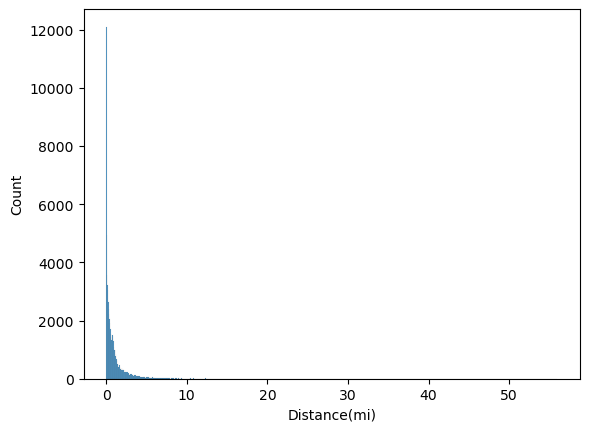

In [47]:
import seaborn as sns
sns.histplot(data=df, x='Distance(mi)')